Import explore data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

In [7]:
df = pd.read_csv('Bank_Customer_Churn_Prediction.csv')

#add new feature
df['balance_active'] = df['balance'] * df['active_member']

# print(df.dtypes)

#missing data
# print(df.isna().sum())

#Country average and user number
churn_rate_country = df.groupby('country')['churn'].agg(lambda x: x.sum() / x.count())
# print(churn_rate_country)

user_num = df.groupby('country')['customer_id'].nunique()
# print(user_num)

#pairplot 
# sns.pairplot(df)
# plt.show()

Data preprocessing and Feature selection and engineering

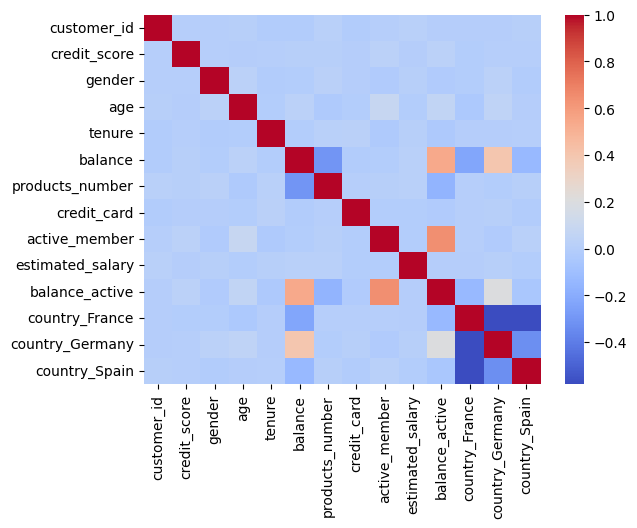

In [8]:
# gender dummy
gender_dict = {'Female': 1, 'Male': 0}
df['gender'] = df['gender'].map(gender_dict)

#country dummy
df_dummies = pd.get_dummies(df['country'], prefix='country', dtype=int)
df = pd.concat([df, df_dummies], axis=1)
df.drop('country',axis =1, inplace = True)
# print(df.dtypes)

target = df['churn']
features = df.drop('churn',axis =1) 

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled, columns = features.columns)
# print(features.describe())

#heatmap 
sns.heatmap(features_scaled.corr(), annot=False, cmap='coolwarm')
plt.show()

# drop unique identifiers
features_scaled = features_scaled.drop('customer_id', axis=1)


### Logistic Regression

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target,train_size=0.8, random_state= 0)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
print(f'accuracy score: {accuracy}')

precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

print(f'precision score: {precision}')
print(f'recall score: {recall}')
print(f'f1 score: {f1}')

accuracy score: 0.812
precision score: 0.5900621118012422
recall score: 0.2345679012345679
f1 score: 0.33568904593639576


### Random Forests

In [10]:
rf = RandomForestClassifier(random_state= 0, class_weight='balanced')
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



Accuracy: 0.8685
Precision: 0.7669172932330827
Recall: 0.5037037037037037
F1 Score: 0.6080476900149031


### KNN

In [20]:
k = 5  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)


y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.828
Precision: 0.610909090909091
Recall: 0.4148148148148148
F1 Score: 0.49411764705882355


### XGBoost model

In [12]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=0, scale_pos_weight=1)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb}")
print(f"XGBoost Precision: {precision_xgb}")
print(f"XGBoost Recall: {recall_xgb}")
print(f"XGBoost F1 Score: {f1_xgb}")


XGBoost Accuracy: 0.849
XGBoost Precision: 0.6584615384615384
XGBoost Recall: 0.528395061728395
XGBoost F1 Score: 0.5863013698630137


### RandomizedSearchCV

In [18]:
# Expanded parameter grid
param_grid = {
    'n_estimators': [500],
    'max_depth': [5, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [ 2, 4]
}

rf = RandomForestClassifier(random_state=0, class_weight='balanced')

# Stratified K-Fold to ensure balanced splits
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid_search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=100,  
    cv=5,
    scoring='f1',  
    n_jobs=-1,
    random_state=0
)

grid_search.fit(X_train, y_train)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [500]},
                   random_state=0, scoring='f1')

### RandomizedSearchCV best model

In [19]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best F1 Score (CV): {grid_search.best_score_:.2f}")

# Evaluate on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Confusion matrix
print("\nConfusion Matrix:")
print("\nTest Set Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# Display the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
Best F1 Score (CV): 0.63

Confusion Matrix:

Test Set Performance:
Accuracy : 0.8320
Precision: 0.8481
Recall   : 0.8320
F1 Score : 0.8381
Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}


### Feature importances

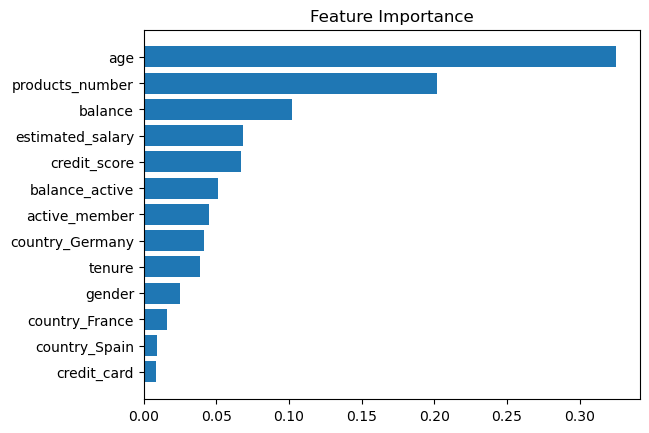

In [56]:
importances = feature_importances = grid_search.best_estimator_.feature_importances_
sorted_index = np.argsort(importances)
labels = X_train.columns[sorted_index]

# Create plot
plt.barh(range(X_train.shape[1]), importances[sorted_index], tick_label=labels)
plt.title('Feature Importance')
plt.show()

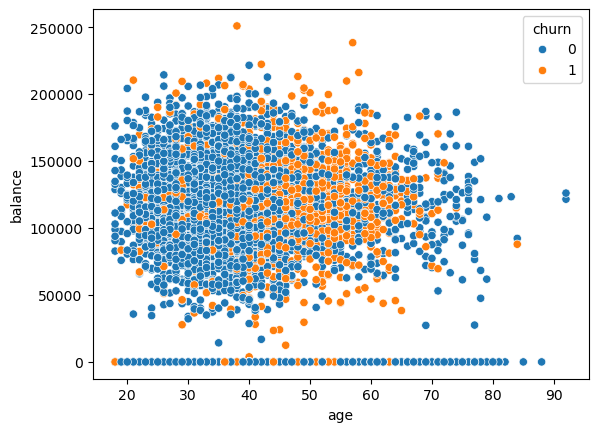

In [57]:
sns.scatterplot(x='age',y='balance',hue='churn',data=df)
plt.show()

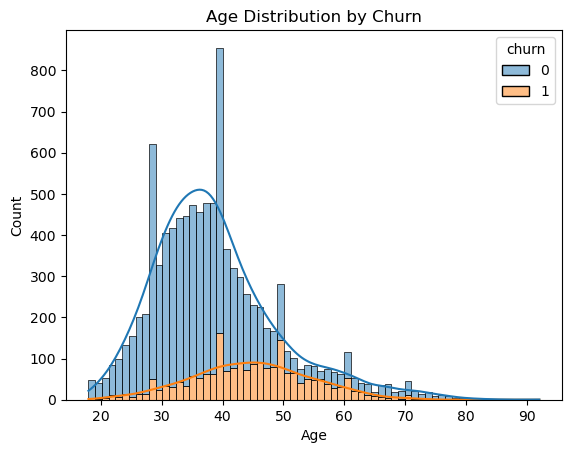

In [58]:
sns.histplot(df, x='age', hue='churn', multiple='stack', kde=True)
plt.title('Age Distribution by Churn')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

/var/folders/59/04rfykkd6m96gklk1909pqyh0000gn/T/ipykernel_4434/3476662232.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_churn = df.groupby(['balance_bin', 'churn']).size().unstack(fill_value=0)


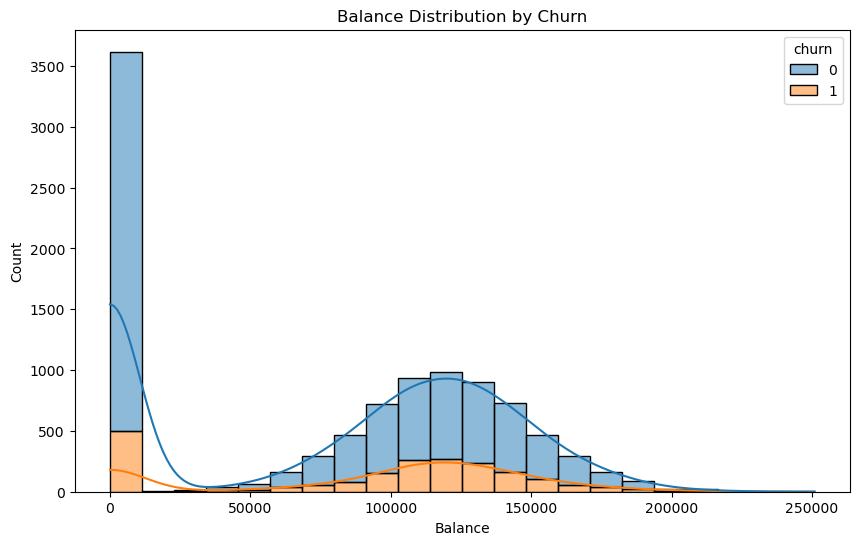

Percentage Table:
                 balance_bin          0           1
0        (-0.001, 11404.459]  86.152570   13.847430
1     (11404.459, 22808.917]  66.666667   33.333333
2     (22808.917, 34213.376]  45.454545   54.545455
3     (34213.376, 45617.835]  69.230769   30.769231
4     (45617.835, 57022.293]  72.307692   27.692308
5     (57022.293, 68426.752]  78.395062   21.604938
6      (68426.752, 79831.21]  81.292517   18.707483
7      (79831.21, 91235.669]  82.340426   17.659574
8    (91235.669, 102640.128]  78.918169   21.081831
9   (102640.128, 114044.586]  72.523962   27.476038
10  (114044.586, 125449.045]  72.560976   27.439024
11  (125449.045, 136853.504]  73.672566   26.327434
12  (136853.504, 148257.962]  77.899045   22.100955
13  (148257.962, 159662.421]  77.185501   22.814499
14   (159662.421, 171066.88]  80.136986   19.863014
15   (171066.88, 182471.338]  77.358491   22.641509
16  (182471.338, 193875.797]  75.555556   24.444444
17  (193875.797, 205280.255]  58.333333   41.6

In [62]:
bins = np.histogram_bin_edges(df['balance'], bins='auto')

# Create a new column to categorize data into bins
df['balance_bin'] = pd.cut(df['balance'], bins=bins, include_lowest=True)

# Calculate percentage for each bin and churn category
bin_churn = df.groupby(['balance_bin', 'churn']).size().unstack(fill_value=0)
bin_churn_percent = bin_churn.div(bin_churn.sum(axis=1), axis=0) * 100

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='balance', hue='churn', multiple='stack', bins=bins, kde=True)
plt.title('Balance Distribution by Churn')
plt.xlabel('Balance')
plt.ylabel('Count')
plt.show()

# Convert the percentage table to a DataFrame
percent_table = bin_churn_percent.reset_index()
percent_table.columns.name = None  # Clear the column index name

# Display the table
print("Percentage Table:")
print(percent_table)

                 Churn Rate
products_number            
1                  0.277144
2                  0.075817
3                  0.827068
4                  1.000000


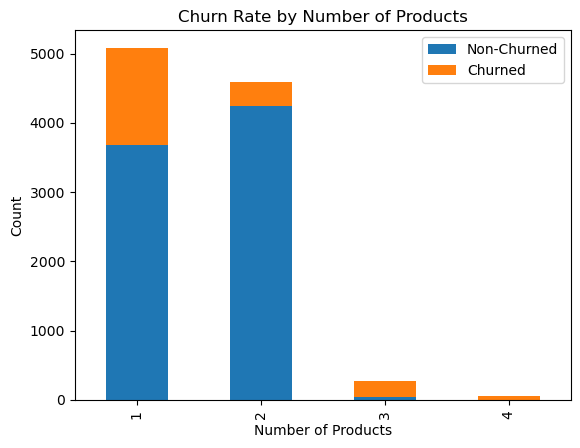

In [60]:
churn_count = df.groupby(['products_number', 'churn']).size().unstack(fill_value=0)
churn_count.plot(kind='bar', stacked=True)
churn_rate = churn_count[1] / churn_count.sum(axis=1) 
print(churn_rate.to_frame(name='Churn Rate'))

plt.title('Churn Rate by Number of Products')
plt.xlabel('Number of Products')
plt.ylabel('Count')
plt.legend(['Non-Churned', 'Churned'])
plt.show()